<a href="https://colab.research.google.com/github/tkoyama010/Colaboratory/blob/master/thermo_coupling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tkoyama010/Colaboratory/blob/master/thermo_coupling.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tkoyama010/Colaboratory/blob/master/thermo_coupling.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
</table>

# GetFEM++とは
GetFEM++ は Python, Matlab そして Scilabのインタフェースを使用可能なC++の汎用有限要素法ライブラリです。このライブラリの目的は有限要素法を用いて線形および非線形偏微分方程式を解くためのフレームワークを提供することが目的です。有限要素近似や数値積分法の選択の柔軟性が特徴の一つです。
([Wikipedia](https://ja.wikipedia.org/wiki/GetFEM%2B%2B)より)
![tripodvonmiseswithmesh](http://getfem.org/_static/tripodvonmiseswithmesh.png)

# コンパイル済みパッケージからのインストール

## Debian / Ubuntuシステム上

GetFEM ++パッケージは、DebianおよびUbuntuディストリビューションの公式リポジトリで入手できます。さまざまなDebianリリースで利用可能なGetFEM++バージョンに関する情報は、 https://packages.debian.org/source/sid/getfem++ などにあり、さまざまなUbuntuリリースに関しては https://launchpad.net/ubuntu/+source/getfem++ を参照してください。GetFEM++（pythonインターフェイスを含む）は、apt updateおよびapt install python-getfem ++を実行することにより、ターミナルからインストールできます。

In [1]:
!sudo apt update && sudo apt install python-getfem++

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:8 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ Packages [79.8 kB]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:13 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 k

# GetFEM++ の基本的な使い方
GetFEM++ の構造は以下のようにまとめることができます。
![getfem_structure1](https://getfem.readthedocs.io/ja/latest/_images/getfem_structure1.png)

GetFEM++ を使用するプログラムは、多くの場合、次の構造となります
```
... define one or more Mesh

... define one or more MeshFem

... define one or more MeshIm

... define a Model and set it up:

    Model.add_fem_variable(MeshFem, "some variable name")

    Model.add_fem_variable(MeshFem, "another variable name")

    Model.add_fem_data(MeshFem, "some data name")

    Model.add_nonlinear_generic_assembly_brick(MeshIm,
                            "copy & paste your PDE weak formulation here", MeshRegion)

    Model.solve(...options)
```
弱形式言語で偏微分方程式項を定義するのではなく(弱形式言語の記号の詳細については [任意の項を計算する - 高水準の汎用的な構築手順 - 弱形式言語](https://getfem.readthedocs.io/ja/latest/userdoc/gasm_high.html#ud-gasm-high) を参照してください)、標準項として定義済みのブリックを使用することもできます。汎用的な楕円項、線形化または有限ひずみ弾性、標準境界条件...など。

# 熱および電気弾性連成の例 (単純な非線形連成問題、モデルオブジェクト、汎用アセンブリ、解析および可視化)

[この](https://getfem.readthedocs.io/ja/latest/tutorial/thermo_coupling.html)例では、変位フィールド、温度フィールド、および電位フィールドの非線形連成のマルチフィジックス問題の簡単な例を紹介します。対応するデモファイルは、 GetFEM++ のテストディレクトリにあります( interface/tests/python )。

## 問題の設定
$\Omega \subset \boldsymbol{R}^2$ は、2次元板の参照配置です( [ここ](https://getfem.readthedocs.io/ja/latest/tutorial/thermo_coupling.html#tut-fig-meshthermo) のジオメトリを参照してください)、ここで厚さ $\varepsilon$ は外部力、電位および加熱に寄与します。ここで、 $\theta : \Omega \rightarrow \boldsymbol{R}$ は( °C の)温度フィールド、 $V : \Omega \rightarrow \boldsymbol{R}$ は電位フィールドです。また、 $u : \Omega \rightarrow \boldsymbol{R}^2$ は膜変位場です。

### 熱問題
プレートの表裏面は、熱伝達係数 $D$ の (20 °C の) 空気と熱交換しており、プレートの側面は断熱であると想定されています。

熱方程式 $\theta$ と境界条件は次のように書くことができます。

$$
\left\{\begin{array}{l}
-\mbox{div}(\varepsilon\kappa(\nabla \theta)) + 2D(\theta - T_0) - \varepsilon\sigma|\nabla V|^2 = 0 ~~ \mbox{ in } \Omega, \\
\kappa\nabla \theta \cdot n = 0 ~~ \mbox{ on } \partial \Omega,
\end{array} \right.
$$

$\kappa$ は熱電導率、 $T_0$ は空気の温度、 $\partial \Omega$ は、領域 $\Omega$ の境界であり $n$ は $\partial \Omega$ 上の $\Omega$ の外向きの単位法線ベクトルです。

項 $\sigma|\nabla V|^2$ は、Joule加熱項に対応する非線形連成項であり、 $\sigma$ は電気伝導率です。

### 電位問題
プレートの左右の側面の間には 0.1V の電位差があるとします。他の面は電気的に絶縁されていると考えます。電位の方程式は次の通りです。

$$
\left\{\begin{array}{l}
-\mbox{div}(\varepsilon\sigma(\nabla V)) = 0 ~~ \mbox{ in } \Omega, \\
\sigma\nabla V \cdot n = 0 ~~ \mbox{ on the top an bottom lateral faces}, \\
V = 0 ~~ \mbox{ on the right lateral face}, \\
V = 0.1 ~~ \mbox{ on the left lateral face}, \\
\end{array} \right.
$$

ここでも $\sigma$ は電気伝導率です。さらに、 $\sigma$ は次のように温度に依存すると考えます。

$$
\sigma = \dfrac{1}{\rho_0(1+\alpha(\theta - T_0))},
$$

ここで $T_0$ は参照温度 (ここでは空気温度) であり、 $\rho_0$ は $T_0$ 上の抵抗温度係数であり、$\alpha$ は第2抵抗温度係数です。

### 変形問題
右側面に加わる力の下でプレートの微小変形を考慮し, プレートの加熱によって影響を受けるとします。変位 $u$ は、次の(線形化された弾性)問題の解になります。

$$
\left\{\begin{array}{l}
-\mbox{div}(\bar{\sigma}(u)) = 0 ~~ \mbox{ in } \Omega, \\
\bar{\sigma}\ n = 0 ~~ \mbox{ on the top an bottom lateral faces}, \\
\bar{\sigma}\ n = F ~~ \mbox{ on the right lateral face}, \\
u = 0 ~~ \mbox{ on the left lateral face},
\end{array} \right.
$$

ここで $F$ は右横方向の境界に加えられる力密度であり、 $\bar{\sigma}(u)$ は次のように定義されたCauchy応力テンソルです。

$$
\bar{\sigma}(u) = \lambda^* \mbox{div}(u) I + 2\mu \bar{\varepsilon}(u) + \beta(T_0-\theta) I,
$$

$\bar{\varepsilon}(u) = (\nabla u + (\nabla u)^T)/2$ は、線形化されたひずみテンソルであり、 $I$ は2次単位テンソルで、 $\lambda^*$, $\mu$ は Lamé 係数であり次のように定義されます。

$$\lambda = \dfrac{E\nu}{(1+\nu)(1-2\nu)}, \\
\mu = \dfrac{E}{2(1+\nu)}, \\
\lambda^* = \dfrac{2\lambda\mu}{\lambda+2*\mu},$$

$E$ は材料のヤング係数であり $\nu$ はポアソン比です。

項 $\beta(T_0-\theta) I$ は、熱膨張の項に対応しています。ここで $\beta = \alpha_{th} E/(1-2\nu)$ で、 $\alpha_{th}$ は熱膨張係数です。

## 弱定式化

方程式の連成系方程式の弱定式化は重要なステップです。有限要素の定式化は弱定式化 (Galerkin近似) に基づいており、弱定式化は追加される項を表現する唯一の方法であるため、これはきわめて重要なステップです。

各偏微分方程式の弱定式化は、未知数に対応する試行関数を式に掛けることにより得られます。未知数はDirichlet条件を満たし条件は均質であるとします。その後 $\Omega$ 領域上の積分と(Greenの式を使用した)部分のいくつかの積分を実行します。偏微分方程式系の弱定式化は次の通りです。

$$
\mbox{Find } \theta, V, u \mbox{ with } V = 0.1, u = 0 \mbox{ on the left face}, V = 0 \mbox{ on the right face}, \\
\int_{\Omega} \varepsilon\kappa\nabla\theta\cdot\nabla\delta_{\theta} + 2D\theta\delta_{\theta}d\Omega = \int_{\Omega} (2DT_0 + \varepsilon\sigma|\nabla V|^2)\delta_{\theta} d\Omega ~~~\mbox{ for all } \delta_{\theta}, \\
\int_{\Omega} \varepsilon\sigma\nabla V\cdot\nabla\delta_V = 0 d\Omega ~~~ \mbox{ for all } \delta_V \mbox{ satisfying } \delta_V = 0 \mbox{ on the left and right faces}, \\
\int_{\Omega} \bar{\sigma}(u):\bar{\varepsilon}(\delta_u)d\Omega = \int_{\Gamma_N} F\cdot \delta_u d\Gamma ~~~ \mbox{ for all } \delta_{u} \mbox{ satisfying } \delta_u = 0 \mbox{ on the left face},
$$

ここで $\delta_{\theta}$, $\delta_V$, $\delta_u$ は、それぞれ、 $\theta$, $V$, $u$ に対応する試験関数です、 $\Gamma_N$ は力密度 $F$ がかかる右の境界を示します。そして $\bar{\sigma}:\bar{\varepsilon}$ は2次テンソル同士のFrobeniusスカラー積です。

## Python での実装とインターフェイス

次に、問題を近似する GetFEM++ の使用法についての詳細なプレゼンテーションを行います。

### 初期化
Python の場合、これは簡単です。 GetFEM++ をグローバルにインポートするだけです(numpy もインポートする必要があります)。

In [0]:
import getfem as gf
import numpy as np

### モデルのパラメータ
ここで、問題のさまざまな物理パラメータおよび数値パラメータを定義しましょう。

In [0]:
epsilon = 1.0  # Thickness of the plate (cm)
E = 21e6  # Young Modulus (N/cm^2)
nu = 0.3  # Poisson ratio
clambda = E * nu / ((1 + nu) * (1 - 2 * nu))  # First Lame coefficient (N/cm^2)
cmu = E / (2 * (1 + nu))  # Second Lame coefficient (N/cm^2)
# Lame coefficient for Plane stress (N/cm^2)
clambdastar = 2 * clambda * cmu / (clambda + 2 * cmu)
F = 100e2  # Force density at the right boundary (N/cm^2)
kappa = 4.0  # Thermal conductivity (W/(cm K))
D = 10.0  # Heat transfer coefficient (W/(K cm^2))
air_temp = 20.0  # Temperature of the air in oC.
alpha_th = 16.6e-6  # Thermal expansion coefficient (/K).
T0 = 20.0  # Reference temperature in oC.
rho_0 = 1.754e-8  # Resistance temperature coefficient at T0 = 20oC
alpha = 0.0039  # Second resistance temperature coefficient.

h = 2.0  # Approximate mesh size
elements_degree = 2  # Degree of the finite element methods

### メッシュ生成
GetFEM++ には、ここで説明するいくつかの制約のあるメッシュ機能があります。ここではそれらを使用するつもりです。しかし、得られたメッシュの品質と適合性は保証していません。そのため、 GetFEM++ のメッシュ作成機能を使用する場合はメッシュを確認することをお勧めします。また、外部メッシャ (例えばGiD または Gmsh) を使用してインポートすることもできます( [メッシュの保存とロード](https://getfem.readthedocs.io/ja/latest/userdoc/bmesh.html#ud-load-save-mesh) をご覧ください)。

領域のジオメトリは、3つの円形の穴がある長方形であるとします ( [得られたメッシュ](https://getfem.readthedocs.io/ja/latest/tutorial/thermo_coupling.html#tut-fig-meshthermo)。 を参照)。ジオメトリは、いくつかの初等幾何と union/setminus 操作によって記述します ( src/getfem/getfem_mesher.h ファイルを参照してください)。以下では、 h はメッシュサイズを表し、 2 はメッシュの次数を表します (これは変換が次数2であり、曲線エッジを使用することを意味します)。

![mesh_thermo](https://getfem.readthedocs.io/ja/latest/_images/mesh_thermo.png)

In [0]:
mo1 = gf.MesherObject("rectangle", [0., 0.], [100., 25.])
mo2 = gf.MesherObject("ball", [25., 12.5], 8.)
mo3 = gf.MesherObject("ball", [50., 12.5], 8.)
mo4 = gf.MesherObject("ball", [75., 12.5], 8.)
mo5 = gf.MesherObject("union", mo2, mo3, mo4)
mo  = gf.MesherObject("set minus", mo1, mo5)

mesh = gf.Mesh("generate", mo, h, 2)

In [0]:
gf.MesherObject?

### 境界の選択
境界のそれぞれの部分には異なる境界条件を設定するため、境界のさまざまな部分には番号を付けます (穴には、熱と電気の絶縁と、応力自由境界条件が想定されます)。したがって、メッシュ上の要素面を選択し、メッシュ領域を定義する必要があります ( メッシュ領域 を参照)、1、2、3、4はそれぞれ右境界、左境界、上境界、下境界です。これらの境界番号は、モデルのブリックで使用されます。

In [0]:
fb1 = mesh.outer_faces_in_box([1.0, 1.0], [99.0, 24.0])  # Boundary of the holes
fb2 = mesh.outer_faces_with_direction([1.0, 0.0], 0.01)  # Right boundary
fb3 = mesh.outer_faces_with_direction([-1.0, 0.0], 0.01)  # Left boundary
fb4 = mesh.outer_faces_with_direction([0.0, 1.0], 0.01)  # Top boundary
fb5 = mesh.outer_faces_with_direction([0.0, -1.0], 0.01)  # Bottom boundary

RIGHT_BOUND = 1
LEFT_BOUND = 2
TOP_BOUND = 3
BOTTOM_BOUND = 4
HOLE_BOUND = 5

mesh.set_region(RIGHT_BOUND, fb2)
mesh.set_region(LEFT_BOUND, fb3)
mesh.set_region(TOP_BOUND, fb4)
mesh.set_region(BOTTOM_BOUND, fb5)
mesh.set_region(HOLE_BOUND, fb1)
mesh.region_subtract(RIGHT_BOUND, HOLE_BOUND)
mesh.region_subtract(LEFT_BOUND, HOLE_BOUND)
mesh.region_subtract(TOP_BOUND, HOLE_BOUND)
mesh.region_subtract(BOTTOM_BOUND, HOLE_BOUND)

In [0]:
mesh.outer_faces_in_box?

In [0]:
mesh.outer_faces_with_direction?

In [0]:
mesh.set_region?

### メッシュの描画
メッシュをプレビューし、その妥当性を制御するために、次の手順を使用します。

In [0]:
mesh.export_to_vtk("mesh.vtk");

In [0]:
mesh.export_to_vtk?

Python インターフェイスでは、外部グラフィカルポストプロセッサを使用する必要があります (たとえば、gmsh、[Mayavi2](https://mayavi.readthedocs.io/ja/latest/index.html)、または Paraviewなど)。

In [12]:
!apt install mayavi2
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg> /dev/null
!pip install pyvirtualdisplay

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  avahi-daemon bind9-host cython geoclue-2.0 geoip-database
  gstreamer1.0-plugins-base iio-sensor-proxy javascript-common libaudio2
  libavahi-core7 libavahi-glib1 libbind9-160 libbrotli1 libcap2-bin
  libcdparanoia0 libdaemon0 libdns1100 libgeoclue-2-0 libgeoip1
  libgl1-mesa-glx libgstreamer-plugins-base1.0-0 libgstreamer1.0-0 libhyphen0
  libisc169 libisccc160 libisccfg160 libjs-sphinxdoc libjs-underscore
  liblwres160 libmbim-glib4 libmbim-proxy libmm-glib0 libmng2 libnl-genl-3-200
  libnotify4 libnss-mdns liborc-0.4-0 libpam-cap libqmi-glib5 libqmi-proxy
  libqt4-dbus libqt4-declarative libqt4-designer libqt4-help libqt4-network
  libqt4-script libqt4-scripttools libqt4-sql libqt4-sql-mysql libqt4-svg

No handlers could be found for logger "pyvirtualdisplay.abstractdisplay"


/usr/lib/python2.7/dist-packages/traits/etsconfig/etsconfig.py:429: UserWarning: Environment variable "HOME" not set, setting home directory to /tmp
  (environment_variable, parent_directory))


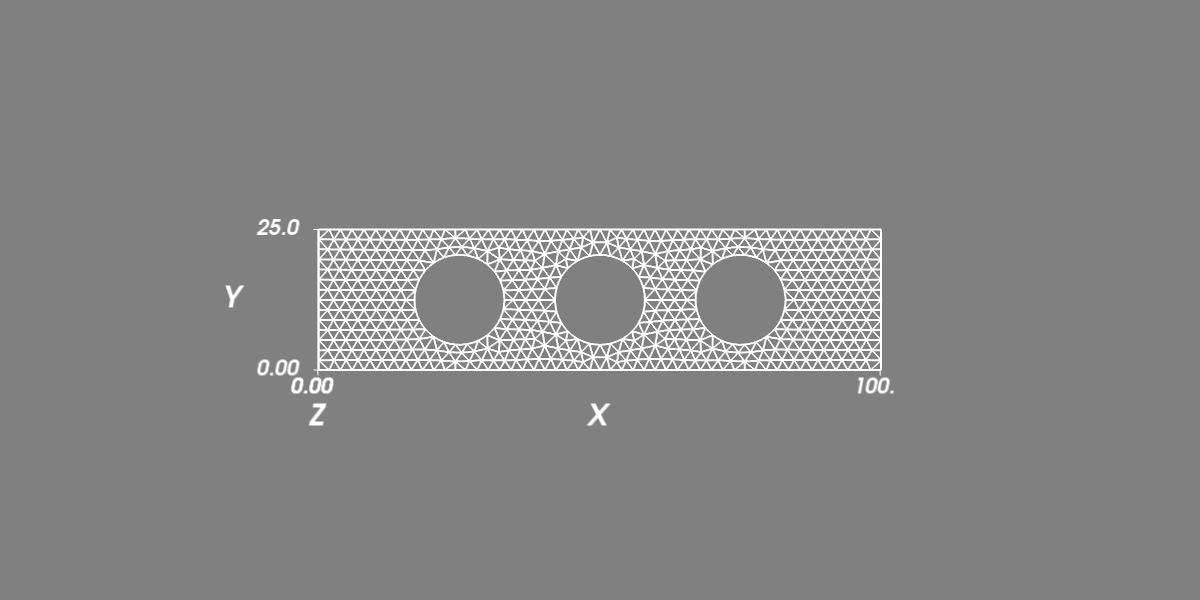

In [13]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 480))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)
!mkdir /tmp/.enthought
!mkdir /tmp/.enthought/mayavi_e3
!mayavi2 --offscreen -d mesh.vtk -m Axes -f ExtractEdges -m Surface -s "scene.save('mesh.png', size=(1200, 600))"
from IPython.display import Image, display_png
display_png(Image("mesh.png"))

### 有限要素法と積分法の定義

3つの有限要素法を定義します。最初の1つは、変位フィールドを近似する mfu です。

In [0]:
mfu = gf.MeshFem(mesh, 2)
mfu.set_classical_fem(elements_degree)

ここで、 2 はベクトル場の次元を表します。2行目は、使用する有限要素を設定します。 classical_finite_element は、連続したLagrange要素を意味し、elements_degree は 2 に設定されています。これは2次の (アイソパラメトリック) 要素を使用することを意味します。

In [0]:
!mfu.set_classical_fem?

GetFEM++ では、既存の有限要素法を幅広く選択肢できます。 [付録A.有限要素法リスト](https://getfem.readthedocs.io/ja/latest/userdoc/appendixA.html#ud-appendixa) を参照してください。しかし、実際には Lagrange 有限要素法が最も使用されています。

第2の有限要素法はスカラーで、温度場と電位場の両方を近似する mft です。単一の有限要素法で任意の数の有限要素変数を近似すると便利です。

In [0]:
mft = gf.MeshFem(mesh, 1)
mft.set_classical_fem(elements_degree)

3番目の有限要素法は不連続なスカラーLagrangeで、1変数の導関数を補間することができます (たとえば、Von Mises応力の補間)。

In [0]:
mfvm = gf.MeshFem(mesh, 1)
mfvm.set_classical_discontinuous_fem(elements_degree)

In [0]:
!mfvm.set_classical_discontinuous_fem?

最後に定義するのは、積分法 mim です。GetFEM++ にデフォルトの積分法はありません。したがって、これは積分法を定義するためには必須です。もちろん、積分法の次数は、選択された有限要素法に好都合な積分を行うため、十分に選定しなければなりません。ここでは、 elements_degree の2乗で十分です。

In [0]:
mim = gf.MeshIm(mesh, pow(elements_degree,2))

### モデルの定義

GetFEM++ のモデルオブジェクトは(未知)変数、データ、およびモデルブリックと呼ばれるものの集まりです。モデルブリックは、単一の変数か、複数の変数をリンクしているモデルの一部 (線形または非線形項) です。これらは、(接線) 線形システムの構築のために使用されます (詳細については [modelオブジェクト](https://getfem.readthedocs.io/ja/latest/userdoc/model_object.html#ud-model-object) を参照してください)。

直接構築を行い(接線) 線形システムを作成することも可能なため、モデルオブジェクトを使用することは厳密には必須ではありません。しかし、モデルオブジェクトは、モデルのほとんどの既往な部分が事前にプログラムされているので、モデルの素早い構築が可能です。 標準境界条件、標準偏微分方程式、制約を処理するための乗数の使用などが整備されています。さらに、いくつかのブリックは、標準ブリック (ジェネリックアセンブリブリック、陽なマトリックスブリックなど) の拡張が可能なように設計されています。そのため、モデルオブジェクトのフレームワークを使用することをお勧めします。

モデルには実数と複素数の2つのバージョンがあります。複素数モデルは複雑な線形システムを解くのに有利な特殊なアプリケーション (例えば、いくつかの電磁気学の問題など) のために予約されています。

計算される3つのフィールドに対応する3つの変数を持つ実際のモデルを宣言してみましょう 。

In [0]:
md=gf.Model("real");
md.add_fem_variable("u", mfu)
md.add_fem_variable("theta", mft)
md.add_fem_variable("V", mft)

### 弾性膜変形問題

ここでは、弾性変形問題から始めましょう。以下の add_isotropic_linearized_elasticity_brick によって追加されている定義済みのブリックを使用します。対応する項は以下の通りです。
$$
\int_{\Omega} (\lambda^* \mbox{div}(u) I + 2\mu \bar{\varepsilon}(u)):\bar{\varepsilon}(\delta_u)d\Omega,
$$
この追加を接線線形システムに対して行います。このモデルブリックを使用するために、 Lamé 係数に対応するデータは、最初にモデルに追加する必要があります。ここでは、 Lamé 係数は、領域に対して一定です。ただし、一部の非定数データを定義することもできます。また、この定義済みのブリックを使用する代わりに、弱形式言語項 add_linear_term(md mim, "lambda*(Div_u*Div_Test_u) + mu*((Grad_u + Grad_u"):Grad_Test_u)" を使用することもできます。

連成項
$$
\int_{\Omega} (\beta\theta I) :\bar{\varepsilon}(\delta_u)d\Omega,
$$
は定義済みのブリックはなく、弱形式言語項 add_linear_term(md mim, "beta\*theta\*Div_Test_u)" を直接使用します。弱形式言語の詳細については、 [任意の項を計算する - 高水準の汎用的な構築手順 - 弱形式言語](https://getfem.readthedocs.io/ja/latest/userdoc/gasm_high.html#ud-gasm-high) を参照してください。基本的に、アセンブリ文字列は、各Gauss点で実行される最適化されたアセンブリ命令のリストでコンパイルされます。

以下のプログラムは、全体の弾性変形方程式を考慮に入れることができます。左側の境界に Dirichlet 条件を規定するために、既定のブリックを使用します。Dirichlet条件を定義するいくつかのオプションがあります( [Dirichlet条件ブリック要素](https://getfem.readthedocs.io/ja/latest/userdoc/model_dirichlet.html#ud-model-dirichlet) を参照)。

In [21]:
md.add_initialized_data("cmu", [cmu])
md.add_initialized_data("clambdastar", [clambdastar])
md.add_initialized_data("T0", [T0])
md.add_isotropic_linearized_elasticity_brick(mim, "u", "clambdastar", "cmu")

md.add_Dirichlet_condition_with_multipliers(mim, "u", elements_degree-1, LEFT_BOUND)
md.add_initialized_data("Fdata", [F*epsilon, 0])
md.add_source_term_brick(mim, "u", "Fdata", RIGHT_BOUND)

md.add_initialized_data("beta", [alpha_th*E/(1-2*nu)])
md.add_linear_generic_assembly_brick(mim, "beta*(T0-theta)*Div_Test_u")

4

### 電位問題
同様に、以下のプログラムは、電位方程式を記述しています。電気伝導率 $\sigma$ と弱形式言語の項の定義方法に注意してください。

In [22]:
sigmaeps = "(eps/(rho_0*(1+alpha*(theta-T0))))"
md.add_initialized_data("eps", [epsilon])
md.add_initialized_data("rho_0", [rho_0])
md.add_initialized_data("alpha", [alpha])
md.add_nonlinear_generic_assembly_brick(mim, sigmaeps+"*(Grad_V.Grad_Test_V)")
md.add_Dirichlet_condition_with_multipliers(mim, "V", elements_degree-1, RIGHT_BOUND)
md.add_initialized_data("DdataV", [0.1])
md.add_Dirichlet_condition_with_multipliers(mim, "V", elements_degree-1, LEFT_BOUND, "DdataV")

7

### 熱問題

ここで、熱問題を記述するプログラムは次の通りです。

In [23]:
md.add_initialized_data("kaeps", [kappa*epsilon])
md.add_generic_elliptic_brick(mim, "theta", "kaeps")
md.add_initialized_data("D2", [D*2])
md.add_initialized_data("D2airt", [air_temp*D*2])
md.add_mass_brick(mim, "theta", "D2")
md.add_source_term_brick(mim, "theta", "D2airt")

md.add_nonlinear_generic_assembly_brick(mim, "-"+sigmaeps+"*Norm_sqr(Grad_V)*Test_theta")

11

### モデルの求解

モデルを正しく定義したら、次のようにして簡単に解くことができます。

In [24]:
md.solve("max_res", 1E-9, "max_iter", 100, "noisy")

(4, 1)

問題は大域的に非線形であるため、Newton法を用いて問題を反復的に解きます。数回のイテレーションが必要です (この場合は約4です)。

### 2ステップでのモデルの求解

別の解き方として、最初に熱と電位の問題を解くこともできます。今回のモデルでは、熱および電位は変形に依存しません。熱と電位の問題を解いてから変形の問題を解くには、次のように実行します。

In [25]:
md.disable_variable("u")
md.solve("max_res", 1E-9, "max_iter", 100, "noisy")
md.enable_variable("u")
md.disable_variable("theta")
md.disable_variable("V")
md.solve("max_res", 1E-9, "max_iter", 100, "noisy")

(0, 1)

### 解のエクスポート/可視化

以上で有限要素問題が解けました。図のように解をプロットすることができます。C++ および Python プログラムでは、外部のグラフィカルポストプロセッサを使用する必要があることに注意してください。また、汎用補間を使用して任意の数量を後処理できることにも注意してください(後述の ga_interpolation_Lagrange_fem を参照)。また、複雑なエクスポートやスライスの作成も可能です ( [解の出力と表示](https://getfem.readthedocs.io/ja/latest/userdoc/export.html#ud-export) をご覧ください)。

In [0]:
U = md.variable("u")
V = md.variable("V")
THETA = md.variable("theta")
VM = md.compute_isotropic_linearized_Von_Mises_or_Tresca("u", "clambdastar", "cmu", mfvm)
CO = np.reshape(md.interpolation("-"+sigmaeps+"*Grad_V", mfvm), (2, mfvm.nbdof()), "F")

mfvm.export_to_vtk("displacement_with_von_mises.vtk", mfvm,
                   VM, "Von Mises Stresses", mfu, U, "Displacements")
mft.export_to_vtk("temperature.vtk", mft, THETA, "Temperature")
mft.export_to_vtk("electric_potential.vtk", mft, V, "Electric potential")

/usr/lib/python2.7/dist-packages/traits/etsconfig/etsconfig.py:429: UserWarning: Environment variable "HOME" not set, setting home directory to /tmp
  (environment_variable, parent_directory))


Notebook initialized with x3d backend.


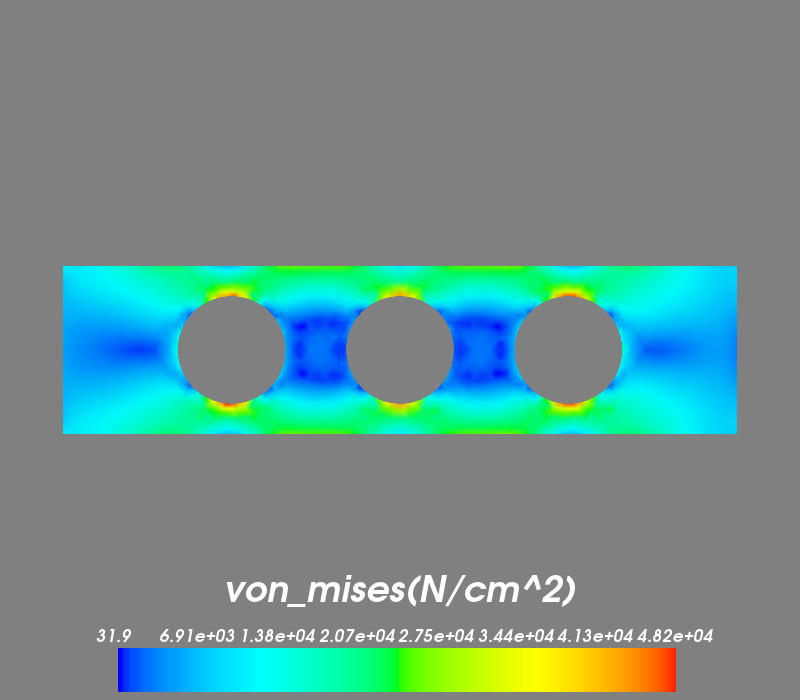

In [27]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 480))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

from mayavi import mlab
mlab.init_notebook()
vtk_file_reader = mlab.pipeline.open("displacement_with_von_mises.vtk")
surface = mlab.pipeline.surface(vtk_file_reader)
mlab.colorbar(title="von_mises(N/cm^2)", orientation="horizontal")
mlab.show()
mlab.savefig("displacement_with_von_mises.png", magnification=2)
mlab.clf()

from IPython.display import Image, display_png
display_png(Image("displacement_with_von_mises.png"))

Notebook initialized with x3d backend.


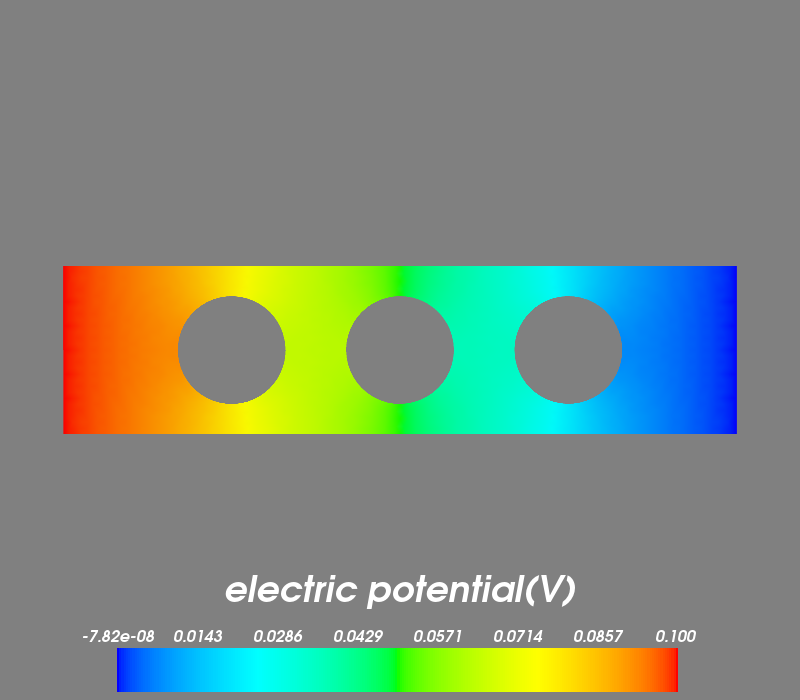

In [28]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 480))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

from mayavi import mlab
mlab.init_notebook()
vtk_file_reader = mlab.pipeline.open("electric_potential.vtk")
surface = mlab.pipeline.surface(vtk_file_reader)
mlab.colorbar(title="electric potential(V)", orientation="horizontal")
mlab.show()
mlab.savefig("electric_potential.png", magnification=2)
mlab.clf()

from IPython.display import Image, display_png
display_png(Image("electric_potential.png"))

Notebook initialized with x3d backend.


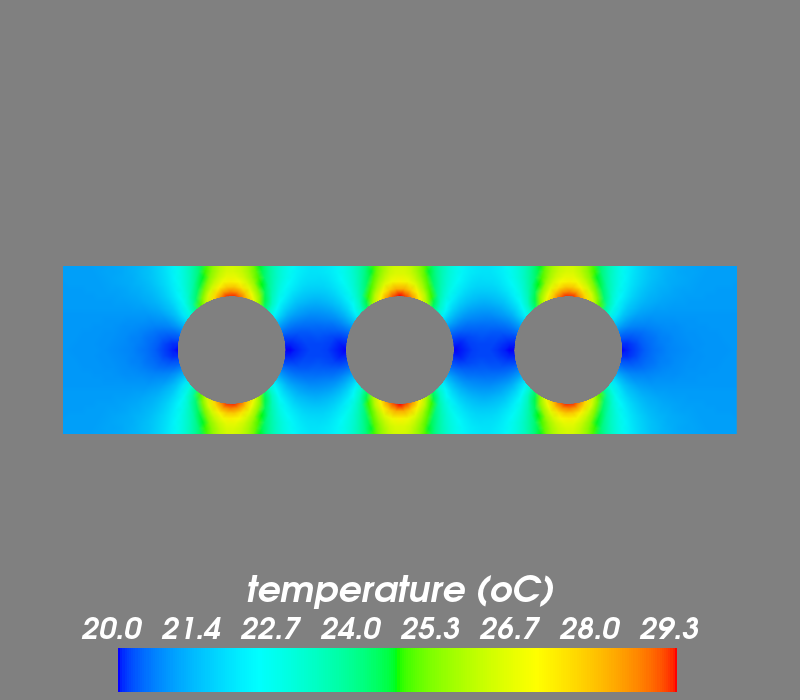

In [29]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 480))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

from mayavi import mlab
mlab.init_notebook()
vtk_file_reader = mlab.pipeline.open("temperature.vtk")
surface = mlab.pipeline.surface(vtk_file_reader)
mlab.colorbar(title="temperature (oC)", orientation="horizontal")
mlab.show()
mlab.savefig("temperature.png", magnification=2)
mlab.clf()

from IPython.display import Image, display_png
display_png(Image("temperature.png"))